# Check variance explained when subcortex is included

In [349]:
%cd work/notebooks

[Errno 2] No such file or directory: 'work/notebooks'
/home/jovyan/work/notebooks


In [1]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [350]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

In [377]:
# pca_hcpex_ds8 = gradientVersion('pca').fit('hcpex_ds8')
# pca_hcpmni_ds8 = gradientVersion('pca').fit('hcpmni_ds8')
hcpmni_ds8_noPC1 = regress_out_axes(pca_hcpmni_ds8, 1)
pca_hcpmni_ds8_noPC1 = gradientVersion('pca').fit(hcpmni_ds8_noPC1)

New gradients version: method=pca, kernel=None, sparsity=0, data=(data given)


In [574]:
hcpex_scores = (pca_hcpex_ds8.clean_scores(n_components=3, norm=False))
hcpex_hcp_corr = pca_hcpmni_ds8.corr_scores(pca_hcpex_ds8).loc[:2,:2]

dict_versions = {
    'Cortex + subcortex':pca_hcpex_ds8, 
    'Cortex only': pca_hcpmni_ds8,
    'Cortex minus PC1': pca_hcpmni_ds8_noPC1
}
hcpex_var = (make_var_exp_df(dict_versions)
    .loc[lambda x: x['PC']<=3]
    .assign(PC = ['PC0','PC1','PC2',
                  'PC1','PC2','PC3',
                  'PC2','PC3','PC4'])
    .loc[lambda x: x['PC']!='PC4']
)

In [568]:
list_acc_regions = ['25', 'a24', 'p32', 'p24', 'a24pr', '33pr', 'p24pr']

dict_cortex_regroupings = {
    'Primary_Visual': 'Visual',
    'Early_Visual': 'Visual',
    'Dorsal_Stream_Visual': 'Visual',
    'MT+_Complex_and_Neighboring_Visual_Areas': 'Visual',
    'Somatosensory_and_Motor': 'Somatomotor & Premotor', 
    'Premotor':'Somatomotor & Premotor',
    'Dorsolateral_Prefrontal': 'DLPFC & Frontal',
    'Inferior_Frontal': 'DLPFC & Frontal',
    'ACC': 'ACC',
    'Medial_Temporal': 'Medial Temporal',
    'Subcortex':'Subcortex'
}

def clean_for_PC12_plot(version):
    return (version
        .scores.iloc[:,:2].set_axis(['PC1','PC2'],axis=1)
        .join(fetch_hcp()['info'].loc[lambda x: x['hemisphere']=='L'].set_index('id')[['cortex', 'label']])
        # fill NA cortex as 'subcortex'
        .assign(cortex = lambda x: x['cortex'].fillna('Subcortex'))
        # separate ACC from medial prefrontal
        .assign(cortex = lambda x: np.where(np.isin(x['label'], list_acc_regions), 'ACC', x['cortex']))
        # regroup cortex and set to other if not to label
        # .replace({'cortex': dict_cortex_regroupings})
        .assign(cortex = lambda x: x['cortex'].map(dict_cortex_regroupings).fillna('other'))
    )

df_PC12_plot = (pd.concat(
        {name:clean_for_PC12_plot(version) for name, version in dict_versions.items()}
    ).reset_index(0).rename({'level_0':'version'}, axis=1)
    )
df_PC12_plot

,version,PC1,PC2,cortex,label
label,,,,,
1,Cortex + subcortex,1.215334,9.609980,Visual,V1
3,Cortex + subcortex,4.435043,7.280495,Visual,V6
4,Cortex + subcortex,2.092344,8.027403,Visual,V2
5,Cortex + subcortex,2.377776,7.376894,Visual,V3
6,Cortex + subcortex,3.053351,7.034824,Visual,V4
...,...,...,...,...,...
176,Cortex minus PC1,-1.533179,-0.208005,other,STSva
177,Cortex minus PC1,-0.742314,-2.672796,other,TE1m
178,Cortex minus PC1,-4.329235,1.124447,other,PI


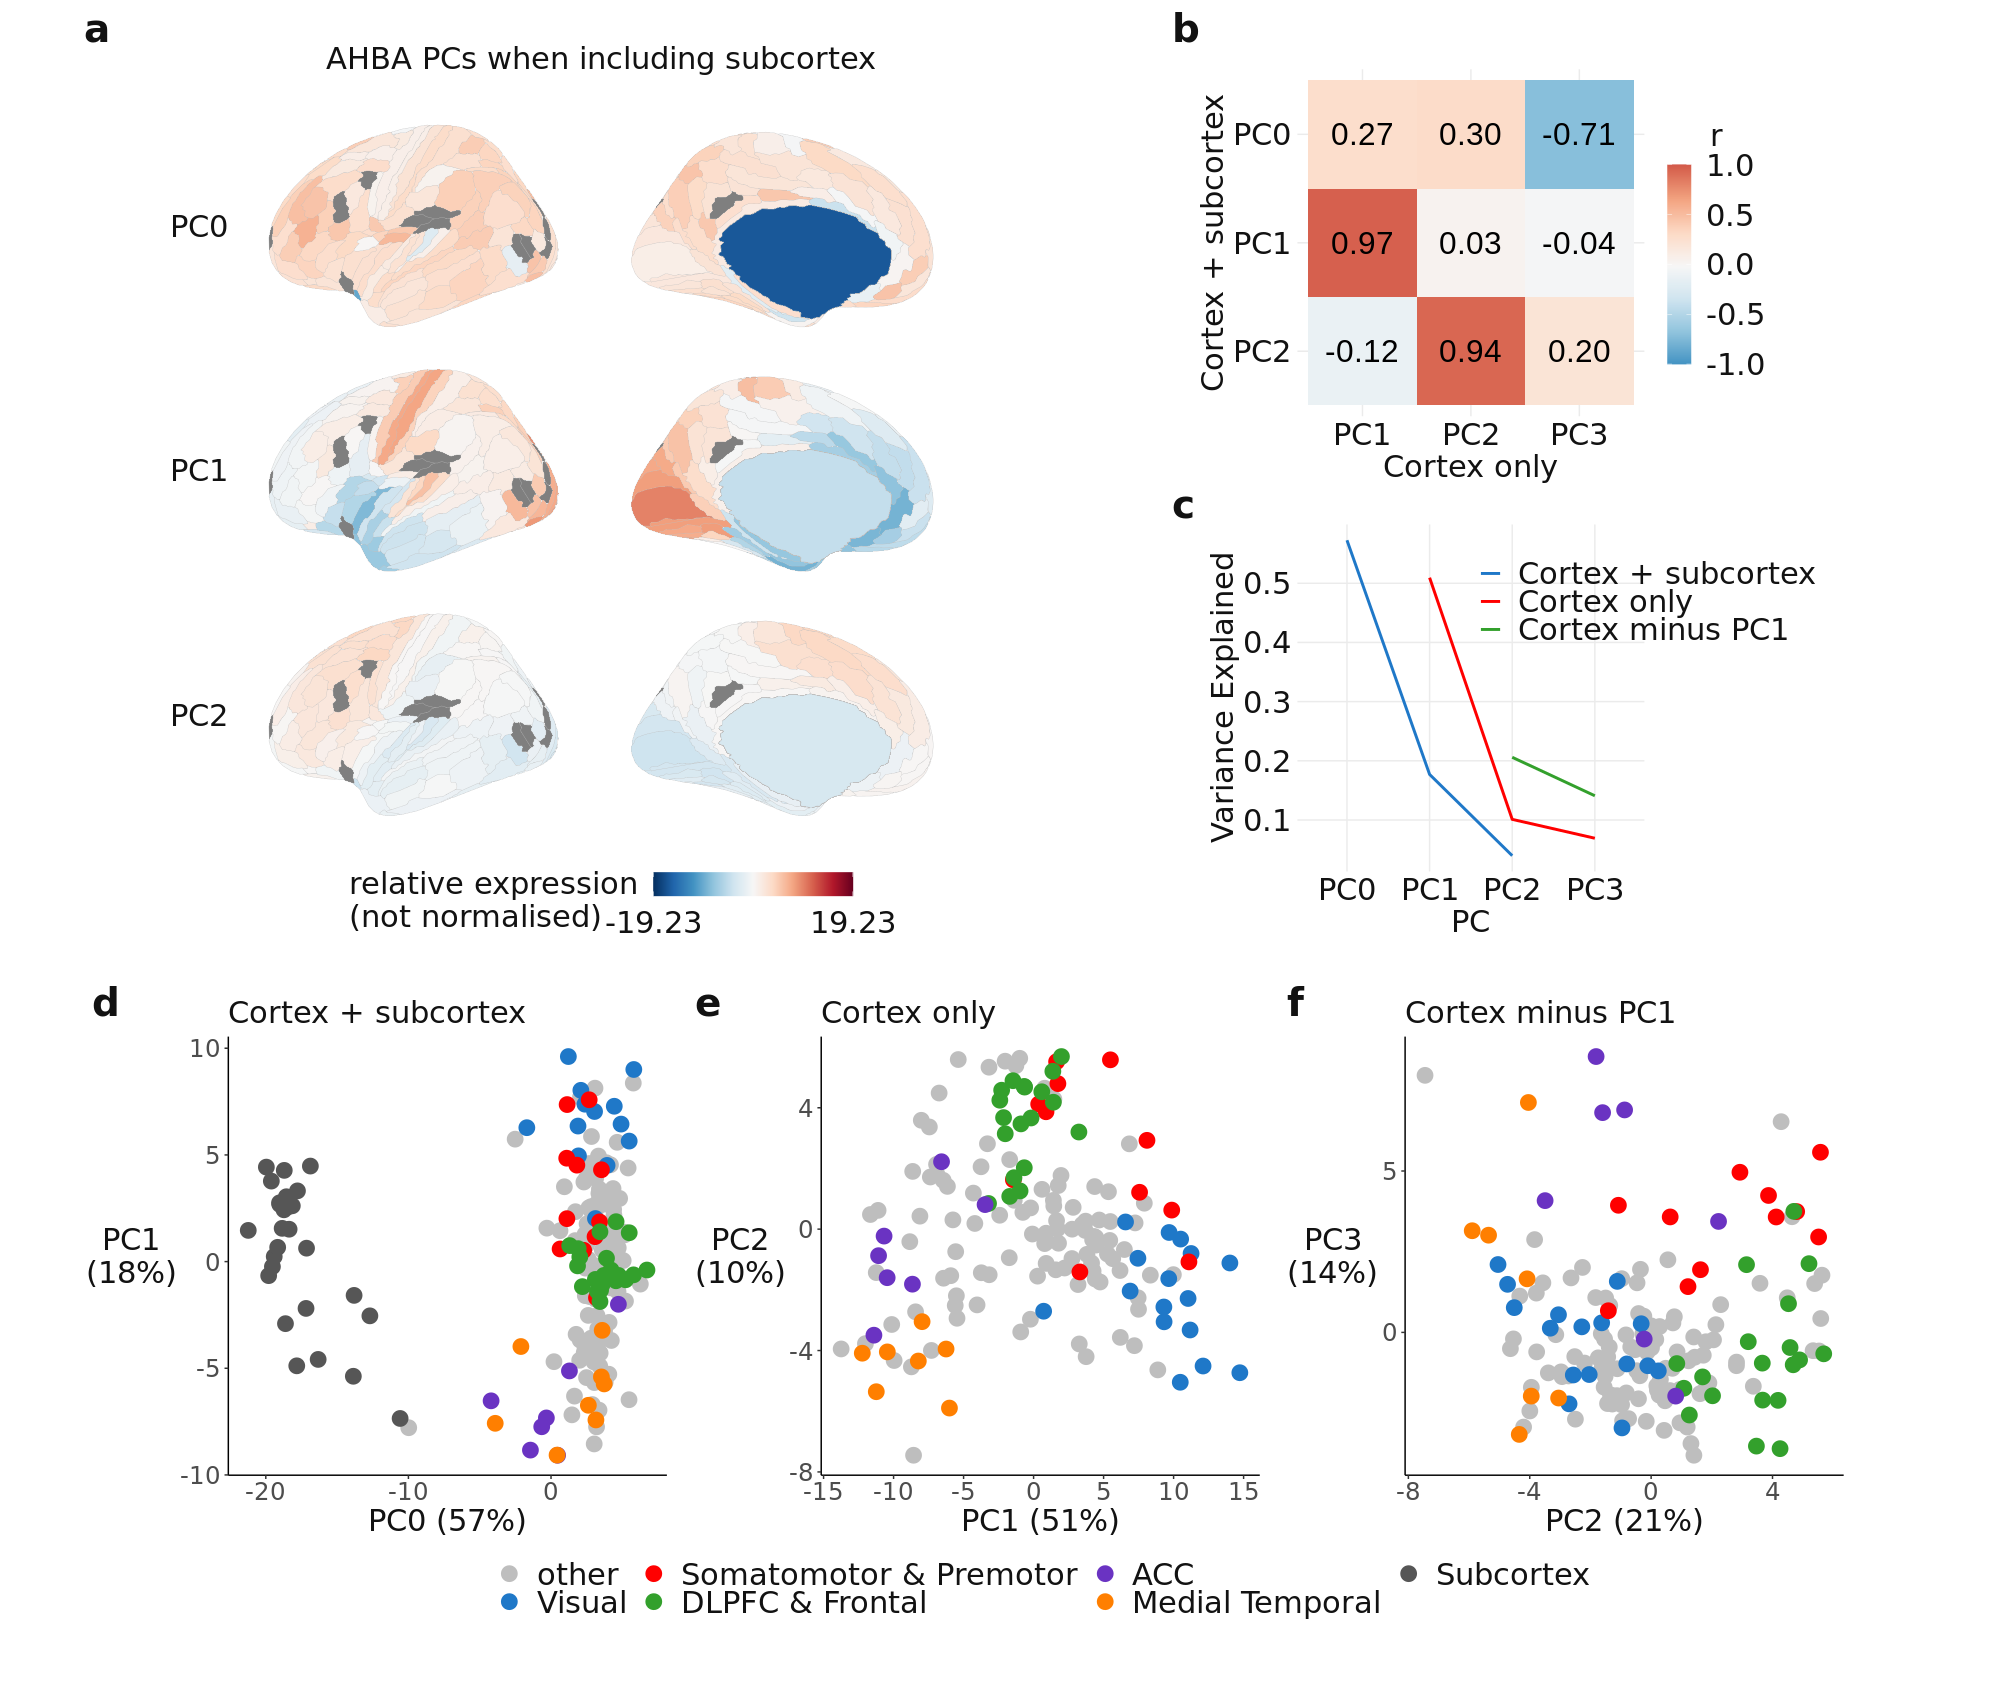

In [580]:
%%R -w 20 -h 17 --units in -r 100 -i hcpex_scores -i hcpex_hcp_corr -i hcpex_var -i df_PC12_plot
source("../code/brainPlots.R")
source("../code/Rplots.R")

plot_regions <- function(df_plot, df_var, xname='PC1', yname='PC2', which_version='Cortex minus PC1') {
    xvar <- df_var %>% filter(version==which_version) %>% .[1, 'var'] %>% round(2)*100
    yvar <- df_var %>% filter(version==which_version) %>% .[2, 'var'] %>% round(2)*100

    df_plot %>%
        filter(version == which_version) %>% 
        rbind(list(version=which_version, PC1=NA, PC2=NA, cortex='Subcortex', label=NA)) %>% 
        # mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>% 
        mutate(cortex = factor(cortex, ordered=TRUE, levels=c('other', unique(.$cortex[!(.$cortex=='other')])))) %>%
        arrange(cortex) %>% 
        ggplot(aes(x=PC1, y=PC2)) + 
        # facet_wrap(~version, scales='free') +
        geom_point(aes(color=cortex), size=5) +
        # geom_text_repel(aes(label=label), data=df_regions %>% filter(cortex != 'other')) +
        # geom_text_repel(aes(label=label), data=data_to_label, size=6) +
        xlab(paste0(xname, ' (',xvar,'%)')) +
        ylab(paste0(yname, '\n(',yvar,'%)')) +
        theme_classic() +
        scale_color_manual(values=c('grey', cols25(10))) +
        guides(color=guide_legend(title='')) +
        theme(legend.position='bottom',
              aspect.ratio=1,
              text=element_text(size=22, color='gray7', family='Calibri'),
              axis.title.y=element_text(angle=0, vjust=.5)) +
        ggtitle(which_version)
}


# special_labels <- c("atop('PC1','(subcortex)')",
#                      "atop('PC2','(cortical PC1)')",
#                      "atop('PC3','(cortical PC2)')")
g1 <- plot_hcp(hcpex_scores, special_labels = c('PC0','PC1','PC2'), facet='h', switch='y',
        name='relative expression\n(not normalised)', title='AHBA PCs when including subcortex') +
        theme(
            legend.position=c(.5,-.1), 
            plot.title=element_text(vjust=-1),
            plot.tag.position=c(0.06,1)
        ) + 
        guides(fill=guide_colorbar(barwidth=10, direction='horizontal'))


g2 <- hcpex_hcp_corr %>% plot_score_corr(rownames=c('PC1','PC2','PC3'), 
        colnames=c('PC0','PC1','PC2'), xlab='Cortex only', ylab='Cortex + subcortex') +
        theme(plot.tag.position=c(-0.05,1))

g3 <- plot_var_exp(hcpex_var) & theme(axis.text=element_text(size=22, color='gray7', family='Calibri')) +
    theme(aspect.ratio=1, plot.tag.position=c(-0.05,1.05))

g4a <- plot_regions(df_PC12_plot, hcpex_var, xname='PC0', yname='PC1', which_version = 'Cortex + subcortex') + theme(plot.tag.position=c(0.1,1))
g4b <- plot_regions(df_PC12_plot, hcpex_var, xname='PC1', yname='PC2', which_version = 'Cortex only') + theme(plot.tag.position=c(0,1))
g4c <- plot_regions(df_PC12_plot, hcpex_var, xname='PC2', yname='PC3', which_version = 'Cortex minus PC1') + theme(plot.tag.position=c(0,1))
g4 <- (g4a + g4b + g4c) + plot_layout(guides='collect') & 
    theme(legend.position='bottom')

# layout <- c(
#     area(t=1,b=28,l=1,r=23),
#     area(t=1,b=14,l=25,r=48),
#     area(t=15,b=28,l=25,r=48),
#     area(t=29,b=48,l=1,r=48)    
# )
    
# plot1 <- g1 + g2 + g3 + g4 + plot_layout(design=layout)

plot <- ((g1 + (g2 / g3)) / g4) + plot_layout(heights=c(5,3))

themed <- plot & theme(
        text=element_text(size=22, color='gray7', family='Calibri'),
        legend.text=element_text(size=22, color='gray7', family='Calibri'),
        plot.title=element_text(size=22, color='gray7', family='Calibri'),
        strip.text=element_text(size=22, color='gray7', family='Calibri'),
        plot.margin = margin(t=10, r=10, b=20, l=10, "pt"),
        plot.tag = element_text(size=28, face='bold', family='Calibri', hjust=0)
)

annotated <- themed + plot_annotation(
  tag_level='a',
  theme = theme(plot.caption = element_textbox_simple(size = 20, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

## Get HCPex working in Abagen with subcortical regions

### First check that we can get subcortical data in DK

In [159]:
expression_dk, counts_dk = get_expression_abagen(
    atlas=fetch_dk(native=False, only_cortex=False), save_name='dk_ds8_subcortex', verbose=2,
    only_cortex=False,
    gene_stability_threshold=0.8, return_counts=True)

INFO: Group-level atlas provided; using MNI coords for tissue samples



Dataset found in ../data/abagen-data/microarray



INFO: Reannotating probes with information from Arnatkevic̆iūtė et al., 2019, NeuroImage
INFO: Filtering probes with intensity-based threshold of 0.5
INFO: 31569 probes survive intensity-based filtering
INFO: Reducing probes indexing same gene with method: diff_stability
INFO: 15633 genes remain after probe filtering + selection
INFO: 786 / 904 samples matched to regions for donor #9861
INFO: 696 / 845 samples matched to regions for donor #10021
INFO: 262 / 353 samples matched to regions for donor #12876
INFO: 405 / 513 samples matched to regions for donor #14380
INFO: 374 / 437 samples matched to regions for donor #15496
INFO: 321 / 414 samples matched to regions for donor #15697
INFO: 84 / 83 regions have >=0 total samples
INFO: 84 / 83 regions have samples from >=0 donors
INFO: Aggregating samples to regions with provided region_agg: donors


3127 genes remain               after filtering for top 0.2 stability


In [534]:
fetch_dk(native=False)['info'].tail(20)

,id,label,hemisphere,structure
63,64,precentral,R,cortex
64,65,precuneus,R,cortex
65,66,rostralanteriorcingulate,R,cortex
66,67,rostralmiddlefrontal,R,cortex
67,68,superiorfrontal,R,cortex
68,69,superiorparietal,R,cortex
69,70,superiortemporal,R,cortex
70,71,supramarginal,R,cortex
71,72,frontalpole,R,cortex
72,73,temporalpole,R,cortex


In [531]:
expression_dk.tail(20)

gene_symbol,A1BG,A1BG-AS1,ABCA6,ABCB7,ABCC12,ABCC5,ABCC8,ABCF2,ABCG1,ABCG2,...,ZNF8,ZNF831,ZNF845,ZNF883,ZSCAN18,ZSCAN26,ZSCAN31,ZSCAN9,ZSWIM9,ZYX
label,,,,,,,,,,,,,,,,,,,,,
23,0.441920,0.610895,0.526071,0.384675,0.609315,0.634502,0.719434,0.697908,0.325819,0.540367,...,0.535506,0.464813,0.361394,0.468722,0.482436,0.573456,0.569513,0.485192,0.545912,0.759489
24,0.434865,0.641036,0.532619,0.427449,0.615628,0.697809,0.762574,0.670600,0.399420,0.441937,...,0.647095,0.465523,0.333119,0.362746,0.534014,0.702303,0.608605,0.564233,0.569645,0.741220
25,0.584672,0.647486,0.292272,0.277498,0.605395,0.698453,0.662047,0.568585,0.391109,0.387064,...,0.563441,0.667051,0.388391,0.503810,0.806261,0.620570,0.551397,0.433697,0.682091,0.527880
26,0.518625,0.653827,0.424763,0.357674,0.704926,0.640688,0.739158,0.697795,0.390262,0.417508,...,0.606009,0.537735,0.423357,0.403397,0.643658,0.663505,0.628140,0.524070,0.516720,0.674904
27,0.519383,0.658453,0.430158,0.372054,0.669759,0.587163,0.703440,0.669454,0.360455,0.436794,...,0.576128,0.540491,0.395437,0.470126,0.630068,0.580166,0.536335,0.401387,0.614151,0.647814
28,0.397621,0.611433,0.480885,0.444473,0.641058,0.677223,0.755851,0.695420,0.399415,0.394562,...,0.644583,0.445148,0.374151,0.391667,0.499298,0.669949,0.642029,0.589988,0.548403,0.759844
29,0.635460,0.695825,0.393392,0.322661,0.633997,0.690587,0.684610,0.608213,0.417341,0.364169,...,0.598337,0.618035,0.453260,0.552179,0.717878,0.652657,0.604296,0.444406,0.616252,0.608188
30,0.409069,0.658867,0.377760,0.350436,0.648579,0.667769,0.699493,0.660586,0.327821,0.393176,...,0.585159,0.505095,0.421466,0.422235,0.599838,0.643468,0.650883,0.519191,0.630552,0.702723
31,0.638054,0.624543,0.446051,0.368552,0.688499,0.647628,0.749939,0.596103,0.503640,0.371816,...,0.672680,0.496874,0.507930,0.436647,0.627214,0.658453,0.573434,0.525512,0.532181,0.570472


### Run Abagen with HCPex

Need to first format info file to run abagen

In [76]:
# Once-off: create info file for HCPex with fields required for abagen
# HCPex_info = (pd.read_csv("../data/parcellations/HCPex.nii.txt",sep=' ', header=None, index_col=0)
#     .set_axis(['hemisphere','label','id'],axis=1)
#     .assign(structure = lambda x: np.where(x['id']>360, 'subcortex/brainstem', 'cortex'))
# )
# HCPex_info.to_csv("../data/parcellations/HCPex_info.csv")

Then run abagen with DS8

In [211]:
expression, counts = get_expression_abagen(
    atlas=fetch_hcp_ex(), save_name='hcpex_ds8', verbose=1,
    only_cortex=False,
    gene_stability_threshold=0.8, return_counts=True)

INFO: Group-level atlas provided; using MNI coords for tissue samples
INFO: Reannotating probes with information from Arnatkevic̆iūtė et al., 2019, NeuroImage
INFO: Filtering probes with intensity-based threshold of 0.5
INFO: 31569 probes survive intensity-based filtering
INFO: Reducing probes indexing same gene with method: diff_stability
INFO: 15633 genes remain after probe filtering + selection
INFO: 567 / 904 samples matched to regions for donor #9861
INFO: 497 / 845 samples matched to regions for donor #10021
INFO: 239 / 353 samples matched to regions for donor #12876
INFO: 320 / 513 samples matched to regions for donor #14380
INFO: 285 / 437 samples matched to regions for donor #15496
INFO: 306 / 414 samples matched to regions for donor #15697
INFO: 427 / 426 regions have >=0 total samples
INFO: 427 / 426 regions have samples from >=0 donors
INFO: Aggregating samples to regions with provided region_agg: donors


3127 genes remain               after filtering for top 0.2 stability


HCPex changes the region labels – use a manual mapping to relabel them
(from https://link.springer.com/article/10.1007/s00429-021-02421-6/tables/1)

In [212]:
df_new_old_labels = pd.read_csv("../data/parcellations/HCPex_label_matching.csv")
dict_new_old_labels = dict(zip(df_new_old_labels['id'], df_new_old_labels['original_id']))

In [213]:
expression = (expression.reset_index().replace({'label':dict_new_old_labels})
    .sort_values('label').set_index('label')
)
expression.to_csv("../data/abagen-data/expression/hcpex_ds8.csv")

In [214]:
expression

gene_symbol,A1BG,A1BG-AS1,AACS,ABCA1,ABCA6,ABCB7,ABCC12,ABCC5,ABCC8,ABCG1,...,ZNF786,ZNF831,ZNF883,ZNRF1,ZRANB3,ZSCAN18,ZSCAN31,ZSCAN9,ZYG11B,ZYX
label,,,,,,,,,,,,,,,,,,,,,
1,0.277774,0.438869,0.593835,0.396832,0.757113,0.681310,0.471092,0.785481,0.846602,0.598871,...,0.764033,0.205958,0.310586,0.689496,0.399119,0.239130,0.722035,0.783529,0.534292,0.863891
3,0.361224,0.527937,0.705254,0.372930,0.583891,0.410704,0.601848,0.580958,0.833051,0.413247,...,0.705537,0.251134,0.348511,0.610830,0.400470,0.374089,0.738263,0.777046,0.647040,0.858150
4,0.305383,0.495796,0.658502,0.419612,0.702489,0.626917,0.495938,0.757413,0.836260,0.559439,...,0.688660,0.282474,0.364751,0.672840,0.467473,0.287531,0.730069,0.682371,0.597941,0.827188
5,0.367542,0.513894,0.603887,0.426718,0.729879,0.515644,0.517405,0.644625,0.805679,0.515970,...,0.656173,0.310174,0.339485,0.547098,0.403298,0.308547,0.710492,0.718963,0.492428,0.792766
6,0.347837,0.501578,0.648485,0.405358,0.673640,0.562234,0.616905,0.762998,0.795710,0.545712,...,0.695337,0.314980,0.379746,0.615028,0.479792,0.369654,0.760201,0.710722,0.552927,0.800851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,0.677227,0.047118,0.032617,0.718635,0.897930,0.845017,0.027478,0.051665,0.081791,0.948571,...,0.053409,0.003566,0.477301,0.005307,0.248472,0.293242,0.274202,0.737378,0.072532,0.191727
389,0.450658,0.055380,0.124640,0.804137,0.867995,0.827352,0.017930,0.079472,0.135034,0.808764,...,0.097539,0.046138,0.662899,0.034703,0.164914,0.533860,0.353936,0.770882,0.197886,0.418535
391,0.308132,0.427950,0.190932,0.827818,0.520236,0.805646,0.018395,0.391130,0.303074,0.773586,...,0.257403,0.070287,0.565496,0.306066,0.393238,0.612773,0.146222,0.809144,0.368277,0.206306


## Test whether PCA creates aligned components

In [215]:
pca_hcpex_ds8 = gradientVersion('pca').fit('hcpex_ds8')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcpex_ds8


Use group MNI HCP atlas (rather than donor atlases) for non-cortex version to be more fair

In [221]:
# pca_hcp_ds8 = gradientVersion('pca').fit('hcp_ds8')
pca_hcpmni_ds8 = gradientVersion('pca').fit('hcpmni_ds8')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcpmni_ds8


In [222]:
pca_hcpex_ds8.corr_scores(pca_hcpmni_ds8)

,0,1,2,3,4
0,0.271587,0.296344,-0.714900,-0.206280,0.198077
1,0.969986,0.030495,-0.042422,-0.018024,0.061200
2,-0.123668,0.938698,0.203686,-0.071025,-0.034545
3,-0.365602,-0.676809,-0.541020,-0.056312,0.079715
4,0.086068,0.116620,-0.482174,0.581802,-0.185251


Yay it works! And how about the variance explained?

In [223]:
pca_hcpex_ds8.eigenvalues / pca_hcpex_ds8.expression.var().sum()

array([0.57270199, 0.17697559, 0.03964346, 0.02235318, 0.01653502])

Perfect.

In [219]:
pca_hcpex_ds8.corr_scores(pca_hcp_ds8)

,0,1,2,3,4
0,0.229307,0.092315,-0.694669,-0.076759,-0.151182
1,0.941052,0.032821,-0.100786,-0.063053,-0.112686
2,-0.081510,0.938077,0.040094,-0.009085,0.095764
3,-0.385372,-0.787474,-0.384823,0.002110,-0.058103
4,0.055447,0.026314,-0.403396,0.557695,0.020864


In [ ]:
pca_hcpex_ds8.corr_scores(pca_hcp_ds8)

,0,1,2,3,4
0,0.938741,-0.002872,-0.120996,-0.062814,-0.123826
1,0.081993,0.936937,-0.041930,-0.031620,0.077015
2,0.053592,0.209610,0.791852,-0.026850,0.015004
3,-0.018413,0.114296,-0.050399,0.697619,-0.003188
4,0.063763,0.034795,-0.236812,-0.227548,0.706408


## Other

###  (testing whether the parcellation images look right)

In [51]:
img = nib.load(fetch_dk(only_cortex=False)['image']['9861'])
# img = nib.load('../data/parcellations/HCP-MMP_1mm.nii.gz')

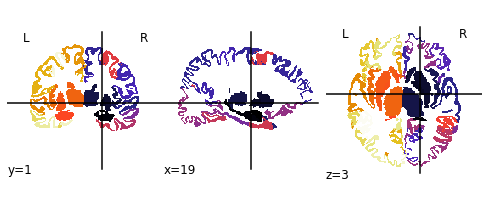

In [52]:
from nilearn import plotting
plotting.plot_img(img, cmap='CMRmap_r')

In [224]:
img = nib.load('../data/parcellations/HCPex.nii.gz')

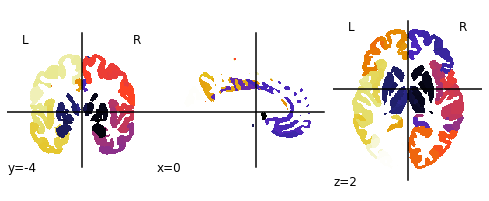

In [225]:
from nilearn import plotting
plotting.plot_img(img, cmap='CMRmap_r')

In [46]:
# img = nib.load(fetch_hcp()['image']['9861'])
img = nib.load('../data/parcellations/HCP-MMP_1mm.nii.gz')

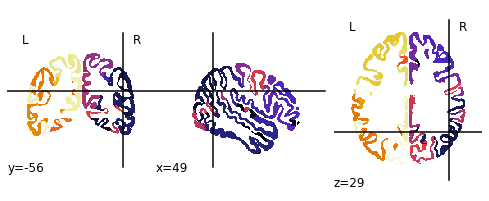

In [47]:
from nilearn import plotting
plotting.plot_img(img, cmap='CMRmap_r')